In this notebook we're creating a CNN to compare it with GCN

In [48]:
# import necessary stuff for
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sentence_transformers import SentenceTransformer

import re
import ast

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import learning_curve

from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB

Pandas setup

In [49]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed
pd.set_option('display.width', 1000)  # Set max width for table
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

In [50]:
def clean_special_chars(value):
    if isinstance(value, str):  
        return value.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    return value 

Reading gab

In [51]:
content_gab = pd.read_csv('gab_reddit_benchmark/gab.csv')

# content_gab = content_gab[:1000]

content_gab["text"] = content_gab["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab["response"] = content_gab["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab["hate_speech_idx"] = content_gab["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

# content_gab["text"] = content_gab["text"].apply(clean_special_chars)
# content_gab["response"] = content_gab["response"].apply(clean_special_chars)

for index, row in content_gab.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

# content_gab = content_gab.applymap(clean_special_chars)
print(content_gab.head(n=10))
print('\n- - - - - -\n')
print(content_gab.columns)
print('\n- - - - - -\n')
print(content_gab.iloc[1]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0                                    1. 39869714\r\n  1. i joined gab to remind myself how retarded ...         [1]      ["Using words that insult one group while defe...
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  1. This is what the left is really scared of. ...         [3]      ['You can disagree with someones opinion witho...
2                   1. 37485560\r\n2. \t37528625\r\n  1. It makes you an asshole.\r\n2. \tGive it to...         [2]      ['Your argument is more rational if you leave ...
3                   1. 39787626\r\n2. \t39794481\r\n  1. So they manage to provide a whole lot of da...         [2]      ["You shouldn't generalize a specific group or...
4  1. 37957930\r\n2. \t39953348\r\n3. \t\t3996521...  1. Hi there, i,m Keith, i hope you are doing w...         [3]      ['If someone is rude it 

Merge posts

In [52]:

def get_first_number(input_string):
    match = re.search(r'\d{2,}', input_string)
    if match:
        return int(match.group())
    return None

content_gab['extracted_id'] = content_gab['id'].apply(get_first_number)

# Find duplicate rows based on 'extracted_id'
duplicates = content_gab[content_gab.duplicated(subset=['extracted_id'], keep=False)]
filtered_groups = []
grouped = content_gab.groupby('extracted_id')
for key, group in grouped:
    if len(group) > 1:
        filtered_groups.append(group)

merged_df = pd.concat(filtered_groups, ignore_index=True)

merged_df.to_csv('gab_reddit_benchmark/gab_groups.csv', index=False)

merged_df = grouped.agg({
    'id': ' '.join,
    'text': ' '.join,
    'hate_speech_idx': ' '.join,
    'response': ' '.join
}).reset_index()
merged_df.to_csv('gab_reddit_benchmark/gab_merged.csv')

df = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
df = df.applymap(lambda x: x.replace('] [', ', ') if isinstance(x, str) else x)
df = df.applymap(lambda x: x.replace(']  [', ', ') if isinstance(x, str) else x)
df = df.applymap(lambda x: 'n/a' if isinstance(x, str) and x.strip() == '' else x)
df.to_csv('gab_reddit_benchmark/gab_merged.csv', index=False)

C:\Users\jakub\AppData\Local\Temp\ipykernel_20104\2213304540.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('] [', ', ') if isinstance(x, str) else x)
C:\Users\jakub\AppData\Local\Temp\ipykernel_20104\2213304540.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace(']  [', ', ') if isinstance(x, str) else x)
C:\Users\jakub\AppData\Local\Temp\ipykernel_20104\2213304540.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'n/a' if isinstance(x, str) and x.strip() == '' else x)


In [53]:
content_gab_m = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
content_gab_m = content_gab_m.drop('Unnamed: 0', axis=1)
content_gab_m = content_gab_m.drop('extracted_id', axis=1)


content_gab_m["text"] = content_gab_m["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab_m["response"] = content_gab_m["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab_m["hate_speech_idx"] = content_gab_m["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

for index, row in content_gab_m.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

print(content_gab_m.head(n=10))
print('\n- - - - - -\n')
print(content_gab_m.columns)
print('\n- - - - - -\n')
print(content_gab_m.iloc[0]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0  1. 37011807\r\n2. \t37012801\r\n3. \t\t3701333...  1. 64% of Hispanics have IQ scores too low to ...     [2, 2, 3]    ['Racist and hate speech will not be tolerated...
1                    1. 37012081\r\n 1. 37012081\r\n  1. LYING CUNT BITCH !!\r\n 1. LYING CUNT BITCH...        [1, 1]    ['Please refrain from using derogatory terms f...
2                                    1. 37012105\r\n  1. Nigger Kills 2 cops https://www.google.com/...           [1]    ['The N word is highly offensive.   All ethnic...
3                   1. 37012146\r\n2. \t37013020\r\n  1. STABBED IN NECK   arrested but no descr   #...           [2]    ['Use of the n-word is unacceptable in our dis...
4  1. 37012285\r\n2. \t37013809\r\n3. \t37013868\r\n  1. Retard 1st Class  w/ Cluster & Ribbon\r\n2....           [1]    ['We should try and not 

In [54]:
def mark_text_labels(text_utterances_length, labels):
    if not labels:
        # return ['other'] * text_utterances_length
        return [0] * text_utterances_length
    new_labels = []
    int_list = ast.literal_eval(labels)
    for i in range(text_utterances_length):
        if i+1 in int_list:
            # new_labels.append('hate_speech')
            new_labels.append(1)
        else:
            # new_labels.append('other')
            new_labels.append(0)
    return new_labels

Splitting 'text' and 'response'

In [55]:
text_column = []
text_labels_column = []
response_column = []
response_labels_column = []

for index, row in content_gab.iterrows():
    text_utterances = row['text'].split('\n')
    text_utterances = list(filter(None, text_utterances))

    for i, t in enumerate(text_utterances):
        text_utterances[i] = clean_special_chars(t)
    text_labels = mark_text_labels(len(text_utterances), row['hate_speech_idx'])

    response_utterances = ast.literal_eval(row['response']) if row['response'] else []
    for i, r in enumerate(response_utterances):
        response_utterances[i] = clean_special_chars(r)
    # response_labels = ['other'] * len(response_utterances)  
    response_labels = [0] * len(response_utterances)  

    
    text_column.append(text_utterances)
    text_labels_column.append(text_labels)
    response_column.append(response_utterances)
    response_labels_column.append(response_labels)

content_gab['text'] = text_column
content_gab['hate_speech_idx'] = text_labels_column
content_gab['response'] = response_column
content_gab['response_labels'] = response_labels_column

content_gab = content_gab.rename(columns={'hate_speech_idx': 'text_labels'})
print(content_gab.head())
print('- - - - ')
print(content_gab.columns)

for index, row in content_gab.iterrows():
    if index == 1:
        continue
    print(row['id'], row['text'], row['text_labels'], row['response'], row['response_labels'])
    break

                          id                                                text                        text_labels                      response                       extracted_id response_labels
0                                    1. 39869714\r\n  [1. i joined gab to remind myself how retarded...         [1]  [Using words that insult one group while defen...    39869714       [0, 0, 0]  
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  [1. This is what the left is really scared of....   [0, 0, 1]  [You can disagree with someones opinion withou...    39845588       [0, 0, 0]  
2                   1. 37485560\r\n2. \t37528625\r\n  [1. It makes you an asshole., 2. Give it to a ...      [0, 1]  [Your argument is more rational if you leave y...    37485560       [0, 0, 0]  
3                   1. 39787626\r\n2. \t39794481\r\n  [1. So they manage to provide a whole lot of d...      [0, 1]  [You shouldn't generalize a specific group or ...    39787626       [0, 0, 0]  
4  1. 37957930\

In [56]:
# get text, first label, response, first response label for each row
texts = []
text_labels = []
for index, row in content_gab.iterrows():
    for i, t in enumerate(row['text']):
        texts.append(t)
        text_labels.append(row['text_labels'][i])

Defining BERT

In [57]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(sentences):
    if isinstance(sentences, list):
        return bert.encode(sentences, show_progress_bar=True).tolist()
    elif isinstance(sentences, str):
        return bert.encode([sentences], show_progress_bar=True).tolist()
    return []

Generate embeddings

In [58]:
# content_gab = content_gab[:200]
# before = time.time()
# content_gab['text_embeddings'] = content_gab['text'].apply(generate_embeddings)
# after_text = time.time()
# print(content_gab.iloc[1]['text_embeddings'])
# print('\nTIME FOR TEXT EMBEDDINGS: ', after_text - before)
# print('\n- - - - - -\n')
# content_gab['response_embeddings'] = content_gab['response'].apply(generate_embeddings)
# after_response = time.time()
# print(content_gab.iloc[2]['response_embeddings'])
# print('\nTIME FOR RESPONSE EMBEDDINGS: ', after_response - after_text)
# print('\n- - - - - -\n')
# embed texts
before = time.time()
text_embeddings = generate_embeddings(texts)
after_text = time.time()
print('\nTIME FOR TEXT EMBEDDINGS: ', after_text - before)
print('\n- - - - - -\n')



Batches: 100%|██████████| 1056/1056 [00:21<00:00, 50.13it/s] 



TIME FOR TEXT EMBEDDINGS:  21.946003437042236

- - - - - -



Prepare labels

In [59]:
# split data into train and test
text_embeddings = np.array(text_embeddings)
print(f"embeddings shape: {text_embeddings.shape}")
text_labels = np.array(text_labels)
print(f"labels shape: {text_labels.shape}")

text_embeddings = np.stack(text_embeddings, axis=0)
text_labels = np.stack(text_labels, axis=0)
print(f"embeddings shape: {text_embeddings.shape}")
print(f"labels shape: {text_labels.shape}")

X_train, X_test, y_train, y_test = train_test_split(text_embeddings, text_labels, test_size=0.2, random_state=42)

embeddings shape: (33776, 384)
labels shape: (33776,)
embeddings shape: (33776, 384)
labels shape: (33776,)


Train RandomForest

Fold 1 Accuracy: 0.8253
Fold 2 Accuracy: 0.8263
Fold 3 Accuracy: 0.8246
Fold 4 Accuracy: 0.8239
Fold 5 Accuracy: 0.8295
Fold 6 Accuracy: 0.8357
Fold 7 Accuracy: 0.8255
Fold 8 Accuracy: 0.8206
Fold 9 Accuracy: 0.8364
Fold 10 Accuracy: 0.8255
Cross-Validation Accuracy (Mean ± Std): 0.8273 ± 0.0048
Final Test Accuracy: 0.8301
learning curve done
plotting


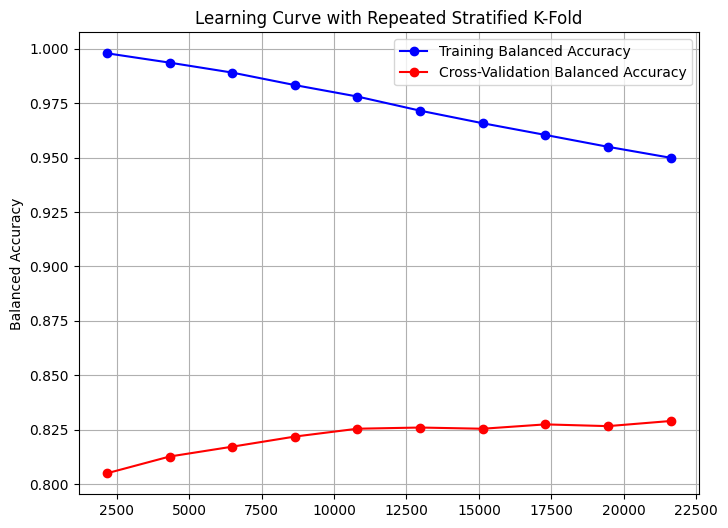

In [ ]:
from sklearn.base import clone

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
rf = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10
)
cv_scores = []

for i, (train_idx, test_idx) in enumerate(rskf.split(X_train, y_train)):
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    model = clone(rf)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    accuracy = balanced_accuracy_score(y_test_fold, y_pred)
    cv_scores.append(accuracy)
    print(f"Fold {i+1} Accuracy: {accuracy:.4f}")

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

final_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f'Cross-Validation Accuracy (Mean ± Std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
print(f'Final Test Accuracy: {final_accuracy:.4f}')

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=rskf, scoring="balanced_accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training Balanced Accuracy")

plt.plot(train_sizes, test_mean, "o-", color="red", label="Cross-Validation Balanced Accuracy")

plt.ylabel("Balanced Accuracy")
plt.title("Learning Curve with Repeated Stratified K-Fold")
plt.legend()
plt.grid()
plt.show()